In [24]:
## By Saina Srivastava

In [25]:
## Based on 
#  - # Link: https://towardsdatascience.com/machine-learning-part-19-time-series-and-autoregressive-integrated-moving-average-model-arima-c1005347b0d7
#  - https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/
#  - https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html?highlight=arima#statsmodels.tsa.arima.model.ARIMA

In [26]:
import numpy as np
import pandas as pd
import datetime

In [27]:
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima_model import ARIMA
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [28]:
file_name = 'data/shampoo.csv'
df = pd.read_csv(file_name, parse_dates = ['Month'], index_col = ['Month'])
df.head()

,Sales
Month,
1-01,266.0
1-02,145.9
1-03,183.1
1-04,119.3
1-05,180.3


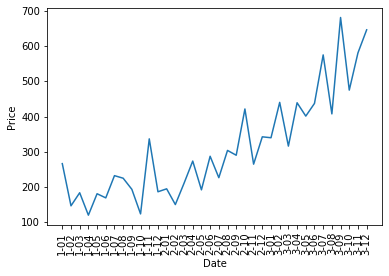

In [29]:
# Reading the file and plotting the basics
plt.xlabel('Date')
plt.ylabel('Price')
plt.xticks(rotation=90)
plt.plot(df)

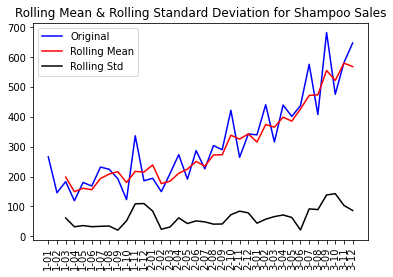

In [30]:
# Panda provides basic time operations
window_size = 3 # Size of window
rolling_mean = df.rolling(window = window_size).mean()
rolling_std = df.rolling(window = window_size).std() # Used for standard deviation

plt.plot(df, color = 'blue', label = 'Original')
plt.plot(rolling_mean, color = 'red', label = 'Rolling Mean')
plt.plot(rolling_std, color = 'black', label = 'Rolling Std')
plt.legend(loc = 'best')
plt.title('Rolling Mean & Rolling Standard Deviation for Shampoo Sales')

plt.xticks(rotation=90)
#for i, t in enumerate(plt.xticklabels()):
#    if (i % 5) != 0:
#        t.set_visible(False)
plt.show()

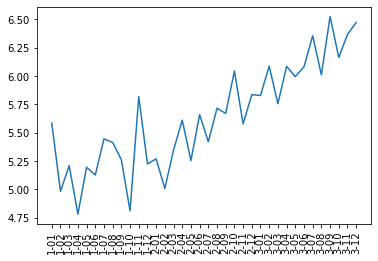

In [34]:
# Showing on a log scale
df_log = np.log(df)

plt.xticks(rotation=90)
plt.plot(df_log)

In [37]:
# Checking if a timeseries is stationary or not
# Stationary: The mean of the series should not grow over time,
#   the variance of the series should not spread over time, and the
#   convariance of'i'th and (i + m)th should not be a funtion of time 
def get_stationarity(timeseries):
    
    # rolling statistics
    rolling_mean = timeseries.rolling(window=12).mean()
    rolling_std = timeseries.rolling(window=12).std()
    
    # rolling statistics plot
    original = plt.plot(timeseries, color='blue', label='Original')
    mean = plt.plot(rolling_mean, color='red', label='Rolling Mean')
    std = plt.plot(rolling_std, color='black', label='Rolling Std')
    plt.xticks(rotation=90)
    plt.legend(loc='best')
    plt.title('Rolling Mean & Standard Deviation')
    plt.show(block=False)
    
    # Dickey–Fuller test:
    result = adfuller(timeseries['Sales'])
    print('ADF Statistic: {}'.format(result[0]))
    print('p-value: {}'.format(result[1]))
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t{}: {}'.format(key, value))

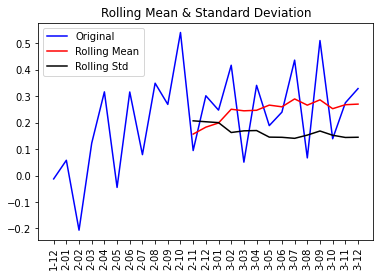

ADF Statistic: -2.8666384708516044
p-value: 0.049367305505793206
Critical Values:
	1%: -3.9240193847656246
	5%: -3.0684982031250003
	10%: -2.67389265625


In [40]:
# To see how it behaves over time
rolling_mean = df_log.rolling(window=12).mean()
df_log_minus_mean = df_log - rolling_mean
df_log_minus_mean.dropna(inplace=True)
get_stationarity(df_log_minus_mean)

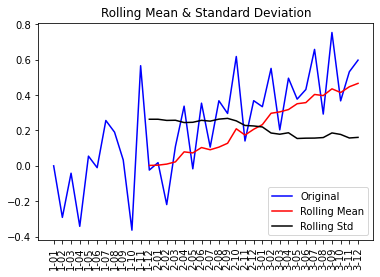

ADF Statistic: -0.9453530717367242
p-value: 0.7726705008438286
Critical Values:
	1%: -3.7238633119999998
	5%: -2.98648896
	10%: -2.6328004


In [41]:
# Used to turn the timeframe into a stationary one
rolling_mean_exp_decay = df_log.ewm(halflife=12, min_periods=0, adjust=True).mean()
df_log_exp_decay = df_log - rolling_mean_exp_decay

df_log_exp_decay.dropna(inplace=True)
get_stationarity(df_log_exp_decay)

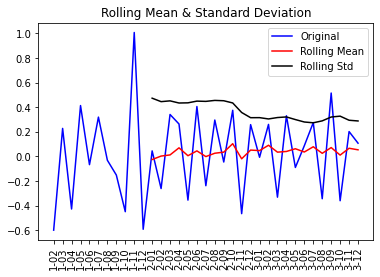

ADF Statistic: -2.1682021458141545
p-value: 0.2179879382560299
Critical Values:
	1%: -3.7377092158564813
	5%: -2.9922162731481485
	10%: -2.635746736111111


In [42]:
# Another method to determine if there is a better method to turn a 
# moving time series into a stationary one
df_log_shift = df_log - df_log.shift()
df_log_shift.dropna(inplace=True)
get_stationarity(df_log_shift)

In [55]:
## Fit model using ARIMA
# p: The number of lag observations included in the model, also called the lag order.
# d: The number of times that the raw observations are differenced, also called the degree of differencing.
# q: The size of the moving average window, also called the order of moving average.
model = ARIMA(df_log, order=(5,1,0))
model_fit = model.fit()
# summary of fit model
print(model_fit.summary())

/Users/biplavs/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/biplavs/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


                             ARIMA Model Results                              
Dep. Variable:                D.Sales   No. Observations:                   35
Model:                 ARIMA(5, 1, 0)   Log Likelihood                   3.140
Method:                       css-mle   S.D. of innovations              0.214
Date:                Mon, 22 Feb 2021   AIC                              7.721
Time:                        18:48:59   BIC                             18.608
Sample:                             1   HQIC                            11.479
                                                                              
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
const             0.0381      0.008      4.660      0.000       0.022       0.054
ar.L1.D.Sales    -1.1963      0.188     -6.372      0.000      -1.564      -0.828
ar.L2.D.Sales    -0.9537      0.286     

In [46]:
# Building ARIMA model
# p: The number of lag observations included in the model, also called the lag order.
# d: The number of times that the raw observations are differenced, also called the degree of differencing.
# q: The size of the moving average window, also called the order of moving average.
model = ARIMA(df_log, order=(0,1,2))

/Users/biplavs/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'
/Users/biplavs/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:213: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  warnings.warn('An unsupported index was provided and will be'


In [47]:
# Fit the model. 
# Result form is here: https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMAResults.html
results = model.fit(disp=-1)


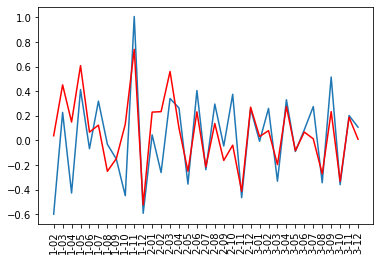

In [49]:
# Show
plt.xticks(rotation=90)
plt.plot(df_log_shift)

plt.plot(results.fittedvalues, color='red')

/Users/biplavs/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/Users/biplavs/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'
/Users/biplavs/opt/anaconda3/lib/python3.8/site-packages/statsmodels/tsa/base/tsa_model.py:580: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


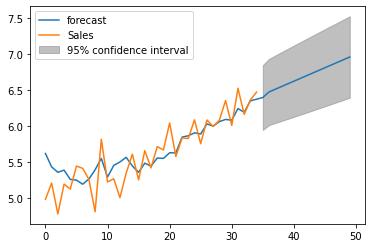

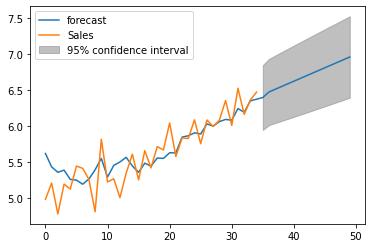

In [53]:
# Allows values to be predicted in future
results.plot_predict(1,50)